In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
%matplotlib inline

pd.set_option('display.max_columns', None)

In [40]:
print(os.listdir('../../scraper/scraped_data'))
os.chdir('../../scraper/scraped_data')

df_restaurants = pd.read_json('restaurants.json', lines=True).set_index('restaurant_id')
df_reviews = pd.read_json('reviews.json', lines=True)
df_users = pd.read_json('users.json', lines=True)

['restaurants.json', 'reviews.json', 'users.json']


# Pre-processing

In [41]:
def freq_dict_generator(cuisine_list, cuisine_dict):
    """Creation of a dict containing all of the cuisine types. """
    for cuisine in cuisine_list:
        if cuisine not in cuisine_dict:
            cuisine_dict[cuisine] = 1
        else:
            cuisine_dict[cuisine] += 1

def col_evaluation(ls, col_name):
    """ Function used to check if a given cuisine is present in the list of the 'cuisine' column. It is
    used in a parallelised manner."""
    if col_name in ls:
        val = 1
    else:
        val = 0
    return val
            
def generate_cuisine_cols(df, cuisine_dict):
    """ Creation of the columns containing all of the cuisine types in a dataframe. """
    for col_name in cuisine_dict:
        df[col_name] = df['cuisine'].apply(lambda x: col_evaluation(x, col_name))
    return df


def score_builder(text):
    if text != 'Ranking not found':
        rank = int(text[1])
        total_entries = int(text.split()[2].replace(',',''))
        score = (total_entries - rank + 1) / total_entries
        return round(score, 3)
    else:
        return None
    
def town_extractor(text):
    if text != 'Ranking not found':
        return text.split()[-1]
    else:
        return None

def cleaning_pipeline(df):
    cuisine_dict = {}
    df_restaurants_cuisine = df.copy()
    
    # Creates a frequency dictionary containing the occurence of all types of cuisine
    df_restaurants_cuisine['cuisine'].apply(lambda x: freq_dict_generator(x, cuisine_dict))
    
    # Converting reviews as int
    df_restaurants_cuisine['nb_reviews'] = df_restaurants_cuisine['nb_reviews'].str.replace(',','').astype('int64')
    
    # Creates a ranking score in order to compare restaurants competing among a different amount of restaurants
    # in a town. The score of the restaurant ranked i among n restaurants is as such : 
    # Score = (n - i + 1) / n
    df_restaurants_cuisine['score'] = df_restaurants_cuisine['ranking'].apply(lambda x: score_builder(x))
    
    # Extracts the town where the restaurant is located
    df_restaurants_cuisine['town'] = df_restaurants_cuisine['ranking'].apply(lambda x: town_extractor(x))
    
    # Used to generate the columns indicating the cuisine of the restaurant
    df_restaurants_cuisine = generate_cuisine_cols(df_restaurants_cuisine, cuisine_dict)
    
    return df_restaurants_cuisine

In [42]:
df_restaurants_cuisine = cleaning_pipeline(df_restaurants)

In [43]:
df_restaurants_cuisine.head()

,name,nb_reviews,min_price,max_price,cuisine,address,phone_number,website,menu,ranking,rating,score,town,Italian,Pizza,Mediterranean,Indian,Asian,Pakistani,Vegetarian Friendly,International,European,British,Grill,Afghani,Vegan Options,Cafe,Japanese,French,Sushi,Fast food,Lebanese,Contemporary,Steakhouse,Argentinian,Deli,African,Moroccan,Balti,Chinese,Turkish,Seafood,Tuscan,Central-Italian,Neapolitan,Middle Eastern,Bar,Pub,Spanish,Thai,Fusion,Vietnamese,Barbecue,American,Cantonese,Malaysian,Sri Lankan,Street Food,Tibetan,Persian,Nepalese,Hong Kong,Gluten Free Options,Latin,Healthy
restaurant_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,La Dolce Vita,1118,2,3,"[Italian, Pizza, Mediterranean]","195 Waldegrave Road, Teddington, Richmond TW11...",+44 20 8977 8779,Website not scraped,Menu not scraped,#1 of 51 Restaurants in Teddington,5.0,1.000,Teddington,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Giftos Lahore Karahi,647,2,3,"[Indian, Asian, Pakistani]","162-164 The Broadway, Southall, Ealing UB1 1NN...",+44 20 8813 8669,Website not scraped,Menu not scraped,Ranking not found,4.0,NaN,None,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Orpington Citi Kitchen,139,2,3,"[Indian, Asian, Vegetarian Friendly]","82 Cotmandene Crescent, Orpington, Bromley BR5...",+44 20 8302 2222,Website not scraped,Menu not scraped,#2 of 120 Restaurants in Orpington,5.0,0.992,Orpington,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,the Orpington,173,2,3,"[International, European, British]","161 High Street Next door to Iceland, Orpingto...",+44 1689 666900,Website not scraped,Menu not scraped,#1 of 120 Restaurants in Orpington,5.0,1.000,Orpington,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bombaylicious,74,2,3,"[Indian, Asian, Grill]","145 Brighton Road, Coulsdon CR5 2NJ England",+44 20 8660 8915,Website not scraped,Menu not scraped,Ranking not found,5.0,NaN,None,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Restaurants EDA

In [64]:
def cuisine_stats(cuisine_name, df, cols=['nb_reviews', 'min_price', 'max_price', 'rating', 'score', 'town']):
    cols = [cuisine_name] + cols
    df_res = df[cols].groupby(by=cuisine_name).mean()
    return df_res

In [65]:
df_italian = cuisine_stats('Pizza', df_restaurants_cuisine)

df_italian.head(10)

,nb_reviews,min_price,max_price,rating,score
Pizza,,,,,
0,456.242718,2.067961,2.902913,4.631068,0.990722
1,480.380952,1.952381,2.904762,4.619048,0.986222


In [72]:
df_vegan = cuisine_stats('Vegan Options', df_restaurants_cuisine)
df_vegan.head(10)

,nb_reviews,min_price,max_price,rating,score
Vegan Options,,,,,
0,464.452174,2.078261,2.947826,4.626087,0.990376
1,407.666667,1.666667,2.333333,4.666667,0.984143


<AxesSubplot:xlabel='Pizza', ylabel='rating'>

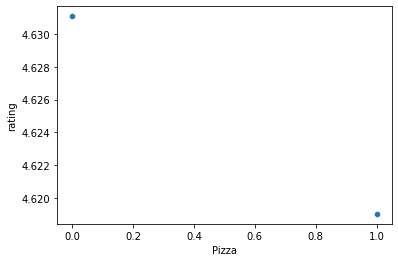

In [70]:
sns.scatterplot(x='Pizza', y='rating', data=df_italian)